# Import

In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import gc
import datetime
import copy
from tqdm.auto import tqdm


import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
import joblib
import catboost as cb
import lightgbm as lgb


import holidays

# Class

## load data

In [2]:
class DataStorage:
    # root = "..\data"
    # root = "/content/drive/MyDrive/predict-energy-behavior-of-prosumers/Data"
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "origin_datetime",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test


## Feature Enegineering

In [3]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude", "origin_datetime")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )
            
        df_features = df_features.with_columns(
            (
                pl.col(f"temperature_forecast_local_0h")
                / (pl.col(f"temperature_forecast_local_168h") + 1e-3)
            ).alias(f"temperature_forecast_local_0h/168h"),
            (
                pl.col(f"surface_solar_radiation_downwards_forecast_local_0h")
                / (pl.col(f"surface_solar_radiation_downwards_forecast_local_168h") + 1e-3)
            ).alias(f"surface_solar_radiation_downwards_forecast_local_0h/168h"),
        )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            
        df_features = df_features.with_columns(
            (
                pl.col(f"temperature_historical_local_48h")
                / (pl.col(f"temperature_historical_local_168h") + 1e-3)
            ).alias(f"temperature_historical_local_48h/168h"),
            (
                pl.col(f"direct_solar_radiation_historical_local_48h")
                / (pl.col(f"direct_solar_radiation_historical_local_168h") + 1e-3)
            ).alias(f"direct_solar_radiation_historical_local_48h/168h"),
            (
                pl.col(f"temperature_historical_24h")
                / (pl.col(f"temperature") + 1e-3)
            ).alias(f"temperature_historical_24h/48h"),
            (
                pl.col(f"direct_solar_radiation_historical_24h")
                / (pl.col(f"direct_solar_radiation") + 1e-3)
            ).alias(f"direct_solar_radiation_historical_24h/48h"),
        )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features[cat_cols] = df_features[cat_cols].astype("category")
        
        if 'row_id' in df_features.columns:
            df_features = df_features.drop("row_id", axis=1)

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

## Model

In [4]:
class Model:
    def __init__(self):
        self.name = "ensembled_model"
        self.target_diff = "target_48h"
        self.is_fitted = False
        
        #local
        # self.model_consumption_catboost = joblib.load(os.path.join( "..\Model", "model_consumption_catboost.pkl"))
        # self.model_production_catboost = joblib.load(os.path.join( "..\Model", "model_production_catboost.pkl"))
        # self.model_consumption_diff_catboost = joblib.load(os.path.join( "..\Model", "model_consumption_diff_catboost.pkl"))
        # self.model_production_diff_catboost = joblib.load(os.path.join( "..\Model", "model_production_diff_catboost.pkl"))

        # self.model_consumption_lightgbm = joblib.load(os.path.join( "..\Model", "model_consumption_lightgbm.pkl"))
        # self.model_production_lightgbm = joblib.load(os.path.join( "..\Model", "model_production_lightgbm.pkl"))
        # self.model_consumption_diff_lightgbm = joblib.load(os.path.join( "..\Model", "model_consumption_diff_lightgbm.pkl"))
        # self.model_production_diff_lightgbm = joblib.load(os.path.join( "..\Model", "model_production_diff_lightgbm.pkl"))
        
        #colab
        # self.model_consumption_catboost = joblib.load(os.path.join( "/content/drive/MyDrive/Model", "model_consumption_catboost.pkl"))
        # self.model_production_catboost = joblib.load(os.path.join( "/content/drive/MyDrive/Model", "model_production_catboost.pkl"))
        # self.model_consumption_diff_catboost = joblib.load(os.path.join( "/content/drive/MyDrive/Model", "model_consumption_diff_catboost.pkl"))
        # self.model_production_diff_catboost = joblib.load(os.path.join( "/content/drive/MyDrive/Model", "model_production_diff_catboost.pkl"))

        # self.model_consumption_lightgbm = joblib.load(os.path.join( "/content/drive/MyDrive/Model", "model_consumption_lightgbm.pkl"))
        # self.model_production_lightgbm = joblib.load(os.path.join( "/content/drive/MyDrive/Model", "model_production_lightgbm.pkl"))
        # self.model_consumption_diff_lightgbm = joblib.load(os.path.join("/content/drive/MyDrive/Model", "model_consumption_diff_lightgbm.pkl"))
        # self.model_production_diff_lightgbm = joblib.load(os.path.join( "/content/drive/MyDrive/Model", "model_production_diff_lightgbm.pkl"))
        
        #kaggle
        self.model_consumption_catboost = joblib.load(os.path.join( "/kaggle/input/cat-lgb-model", "model_consumption_catboost.pkl"))
        self.model_production_catboost = joblib.load(os.path.join( "/kaggle/input/cat-lgb-model", "model_production_catboost.pkl"))
        self.model_consumption_diff_catboost = joblib.load(os.path.join( "/kaggle/input/cat-lgb-model", "model_consumption_diff_catboost.pkl"))
        self.model_production_diff_catboost = joblib.load(os.path.join( "/kaggle/input/cat-lgb-model", "model_production_diff_catboost.pkl"))

        self.model_consumption_lightgbm = joblib.load(os.path.join( "/kaggle/input/cat-lgb-model", "model_consumption_lightgbm.pkl"))
        self.model_production_lightgbm = joblib.load(os.path.join( "/kaggle/input/cat-lgb-model", "model_production_lightgbm.pkl"))
        self.model_consumption_diff_lightgbm = joblib.load(os.path.join( "/kaggle/input/cat-lgb-model", "model_consumption_diff_lightgbm.pkl"))
        self.model_production_diff_lightgbm = joblib.load(os.path.join( "/kaggle/input/cat-lgb-model", "model_production_diff_lightgbm.pkl"))



        self.model_consumption = VotingRegressor(estimators=[('catboost_consumption', self.model_consumption_catboost), 
                                                                      ('lightgbm_consumption', self.model_consumption_lightgbm)],
                                                                      weights=[0.2, 0.8])
        self.model_consumption_diff = VotingRegressor(estimators=[('catboost_consumption_diff', self.model_consumption_diff_catboost), 
                                                                           ('lightgbm_consumption_diff', self.model_consumption_diff_lightgbm)],
                                                                           weights=[0.2, 0.8])
        self.model_production = VotingRegressor(estimators=[('catboost_production', self.model_production_catboost), 
                                                                     ('lightgbm_production', self.model_production_lightgbm)],
                                                                     weights=[0.2, 0.8])
        self.model_production_diff = VotingRegressor(estimators=[('catboost_production_diff', self.model_production_diff_catboost),                                                                
                                                                          ('lightgbm_production_diff', self.model_production_diff_lightgbm)],
                                                                            weights=[0.2, 0.8])


    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"],
        )
        self.model_consumption_diff.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask][self.target_diff].fillna(0),
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"],
        )
        self.model_production_diff.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask][self.target_diff].fillna(0),
        )

        self.is_fitted = True

    def save(self):
        # joblib.dump(self.model_consumption, os.path.join( "..\Model", "model_consumption_VotingRegressor.pkl"))
        # joblib.dump(self.model_production, os.path.join( "..\Model", "model_production_VotingRegressor.pkl"))
        # joblib.dump(self.model_consumption_diff, os.path.join( "..\Model", "model_consumption_diff_VotingRegressor.pkl"))
        # joblib.dump(self.model_production_diff, os.path.join( "..\Model", "model_production_diff_VotingRegressor.pkl")) 

        #colab
        # joblib.dump(self.model_consumption, os.path.join( "/content/drive/MyDrive/Model", "model_consumption_VotingRegressor.pkl"))
        # joblib.dump(self.model_production, os.path.join( "/content/drive/MyDrive/Model", "model_production_VotingRegressor.pkl"))
        # joblib.dump(self.model_consumption_diff, os.path.join( "/content/drive/MyDrive/Model", "model_consumption_diff_VotingRegressor.pkl"))
        # joblib.dump(self.model_production_diff, os.path.join( "/content/drive/MyDrive/Model", "model_production_diff_VotingRegressor.pkl"))

        #kaggle
        joblib.dump(self.model_consumption, os.path.join( "/kaggle/working", "model_consumption_VotingRegressor.pkl"))
        joblib.dump(self.model_production, os.path.join( "/kaggle/working", "model_production_VotingRegressor.pkl"))
        joblib.dump(self.model_consumption_diff, os.path.join( "/kaggle/working", "model_consumption_diff_VotingRegressor.pkl"))
        joblib.dump(self.model_production_diff, os.path.join( "/kaggle/working", "model_production_diff_VotingRegressor.pkl"))

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            self.model_consumption.predict(df_features[mask]) * 0.5
            + (
                df_features[mask][self.target_diff].fillna(0).values
                + self.model_consumption_diff.predict(df_features[mask])
            )
            * 0.5,
            0,
            np.inf,
        )

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            self.model_production.predict(df_features[mask]) * 0.5
            + (
                df_features[mask][self.target_diff].fillna(0).values
                + self.model_production_diff.predict(df_features[mask])
            )
            * 0.5,
            0,
            np.inf,
        )

        return predictions

## Validation

In [5]:
class Validation:
    def __init__(self, validation_start, validation_end, data_storage):
        self.validation_start = validation_start
        self.validation_end = validation_end
        self.data_storage_global = data_storage
        self.data_storage_train = self._generate_train_data_storage()
        self.iter_test = self._generate_iter_test()

    def _generate_train_data_storage(self):
        data_storage = copy.deepcopy(self.data_storage_global)

        data_storage.df_data = data_storage.df_data.filter(
            pl.col("datetime")
            < self.validation_start
            - datetime.timedelta(days=1)
            - datetime.timedelta(hours=11)
        )

        data_storage.df_target = data_storage.df_target.filter(
            pl.col("datetime")
            < self.validation_start
            - datetime.timedelta(days=1)
            - datetime.timedelta(hours=11)
        )

        data_storage.df_client = data_storage.df_client.filter(
            pl.col("date")
            < self.validation_start
            - datetime.timedelta(days=1)
            - datetime.timedelta(hours=11 + 23)
        )

        data_storage.df_gas_prices = data_storage.df_gas_prices.filter(
            pl.col("forecast_date")
            < self.validation_start
            - datetime.timedelta(days=1)
            - datetime.timedelta(hours=10)
        )

        data_storage.df_electricity_prices = data_storage.df_electricity_prices.filter(
            pl.col("forecast_date")
            < self.validation_start
            - datetime.timedelta(days=1)
            + datetime.timedelta(hours=13)
        )

        data_storage.df_historical_weather = data_storage.df_historical_weather.filter(
            pl.col("datetime")
            < self.validation_start
            - datetime.timedelta(days=1)
            - datetime.timedelta(hours=0)
        )

        return data_storage

    def _generate_iter_test(self):
        result = []
        df_data = self.data_storage_global.df_data.to_pandas()
        df_target = self.data_storage_global.df_target.to_pandas()
        df_client = self.data_storage_global.df_client.to_pandas()
        df_historical_weather = (
            self.data_storage_global.df_historical_weather.to_pandas()
        )
        df_gas_prices = self.data_storage_global.df_gas_prices.to_pandas()
        df_electricity_prices = (
            self.data_storage_global.df_electricity_prices.to_pandas()
        )
        df_forecast_weather = self.data_storage_global.df_forecast_weather.to_pandas()

        for current_time in pd.date_range(
            self.validation_start, self.validation_end, freq="D"
        ):
            df_test = df_data[
                (df_data["datetime"] >= current_time + datetime.timedelta(hours=13))
                & (
                    df_data["datetime"]
                    < current_time + datetime.timedelta(hours=13 + 24)
                )
            ]

            df_sample_prediction = df_test.copy().rename(
                columns={"target": "real_target"}
            )
            df_test.drop(columns=["target"], inplace=True)

            df_new_target = df_target[
                (
                    df_target["datetime"]
                    >= current_time - datetime.timedelta(hours=11 + 24)
                )
                & (df_target["datetime"] < current_time - datetime.timedelta(hours=11))
            ]

            df_new_client = df_client[
                (df_client["date"] >= current_time - datetime.timedelta(hours=11 + 24))
                & (df_client["date"] < current_time - datetime.timedelta(hours=11 + 23))
            ]

            df_new_historical_weather = df_historical_weather[
                (
                    df_historical_weather["datetime"]
                    >= current_time - datetime.timedelta(hours=24)
                )
                & (
                    df_historical_weather["datetime"]
                    < current_time - datetime.timedelta(hours=0)
                )
            ]

            df_new_electricity_prices = df_electricity_prices[
                (
                    df_electricity_prices["forecast_date"]
                    >= current_time - datetime.timedelta(hours=11)
                )
                & (
                    df_electricity_prices["forecast_date"]
                    < current_time + datetime.timedelta(hours=13)
                )
            ]

            df_new_gas_prices = df_gas_prices[
                (
                    df_gas_prices["forecast_date"]
                    >= current_time - datetime.timedelta(hours=11)
                )
                & (
                    df_gas_prices["forecast_date"]
                    < current_time - datetime.timedelta(hours=10)
                )
            ]

            df_new_forecast_weather = df_forecast_weather[
                (
                    df_forecast_weather["origin_datetime"]
                    >= current_time - datetime.timedelta(hours=9)
                )
                & (
                    df_forecast_weather["origin_datetime"]
                    < current_time - datetime.timedelta(hours=8)
                )
            ]

            result.append(
                (
                    df_test,
                    df_new_target,
                    df_new_client,
                    df_new_historical_weather,
                    df_new_forecast_weather,
                    df_new_electricity_prices,
                    df_new_gas_prices,
                    df_sample_prediction,
                )
            )

        return result

    def calculate_validation_score(self, features_generator_class, model):
        data_storage = copy.deepcopy(self.data_storage_train)
        features_generator = features_generator_class(data_storage)
        df_train_features = features_generator.generate_features(
            data_storage.df_target
        )
        df_train_features = df_train_features[df_train_features["target"].notnull()]

        model.fit(df_train_features) #medel training 
        model.save()#model saving

        predictions = []
        for (
            df_test,
            df_new_target,
            df_new_client,
            df_new_historical_weather,
            df_new_forecast_weather,
            df_new_electricity_prices,
            df_new_gas_prices,
            df_sample_prediction,
        ) in tqdm(self.iter_test):
            data_storage.update_with_new_data(
                df_new_client=df_new_client,
                df_new_gas_prices=df_new_gas_prices,
                df_new_electricity_prices=df_new_electricity_prices,
                df_new_forecast_weather=df_new_forecast_weather,
                df_new_historical_weather=df_new_historical_weather,
                df_new_target=df_new_target,
            )

            df_test = data_storage.preprocess_test(df_test)
            df_test_features = features_generator.generate_features(df_test)
            df_sample_prediction["target"] = model.predict(df_test_features)

            df_sample_prediction["score"] = np.abs(
                df_sample_prediction["target"] - df_sample_prediction["real_target"]
            )
            predictions.append(df_sample_prediction)

        df_predictions = pd.concat(predictions)
        assert (
            df_predictions[df_predictions["real_target"].notnull()]["score"]
            .isnull()
            .mean()
            == 0
        )
        
        data_predictions_each_county_mean_consumption =  df_predictions[df_predictions["is_consumption"] == 1].groupby("county").mean()        
        plt.figure(figsize=(20, 10))
        sns.barplot(x=data_predictions_each_county_mean_consumption.index, y=data_predictions_each_county_mean_consumption["score"])
        plt.title("Consumption_MAE_each_county")
        plt.show()

        data_predictions_each_sagment_mean_production =  df_predictions[df_predictions["is_consumption"] == 0].groupby("county").mean()
        plt.figure(figsize=(20, 10))
        sns.barplot(x=data_predictions_each_sagment_mean_production.index, y=data_predictions_each_sagment_mean_production["score"])
        plt.title("Production_MAE_each_county")
        plt.show()

        data_predictions_each_datetime_mean_consumption =  df_predictions[df_predictions["is_consumption"] == 1].groupby("datetime").mean()
        wide_df1 = pd.DataFrame(data_predictions_each_datetime_mean_consumption, 
                                data_predictions_each_datetime_mean_consumption.index, ["target", "real_target"])
        
        data_predictions_each_datetime_mean_production =  df_predictions[df_predictions["is_consumption"] == 0].groupby("datetime").mean()
        wide_df0 = pd.DataFrame(data_predictions_each_datetime_mean_production, 
                                data_predictions_each_datetime_mean_production.index, ["target", "real_target"])
        plt.figure(figsize=(20, 10))
        sns.lineplot(data=wide_df1)
        plt.title("Mean_Consumption_all_prosumers")
        plt.show()
        plt.figure(figsize=(20, 10))
        plt.title("Mean_Production_all_prosumers")
        sns.lineplot(data=wide_df0)
        plt.show()
       
        if hasattr(model, "name"):
            model_name = model.name
        else:
            model_name = model.__class__.__name__
        
        gc.collect()
        return {"model_name": model_name, "MAE": df_predictions["score"].mean()}

# Initialisation

In [6]:
data_storage = DataStorage()
validation = Validation(
    validation_start=pd.to_datetime('2023-05-17 11:00:00'),
    validation_end=pd.to_datetime('2023-05-30 11:00:00'),
    data_storage=data_storage)

# Model training and Validation

[LightGBM] [Warning] lambda_l1 is set=0.03410311762087645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03410311762087645
[LightGBM] [Warning] lambda_l2 is set=0.9845952843721262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9845952843721262
[LightGBM] [Warning] min_data_in_leaf is set=375, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=375
[LightGBM] [Warning] min_gain_to_split is set=0.5296254111362524, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5296254111362524
[LightGBM] [Warning] feature_fraction is set=0.6370684599391575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6370684599391575


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


  0%|          | 0/14 [00:00<?, ?it/s]

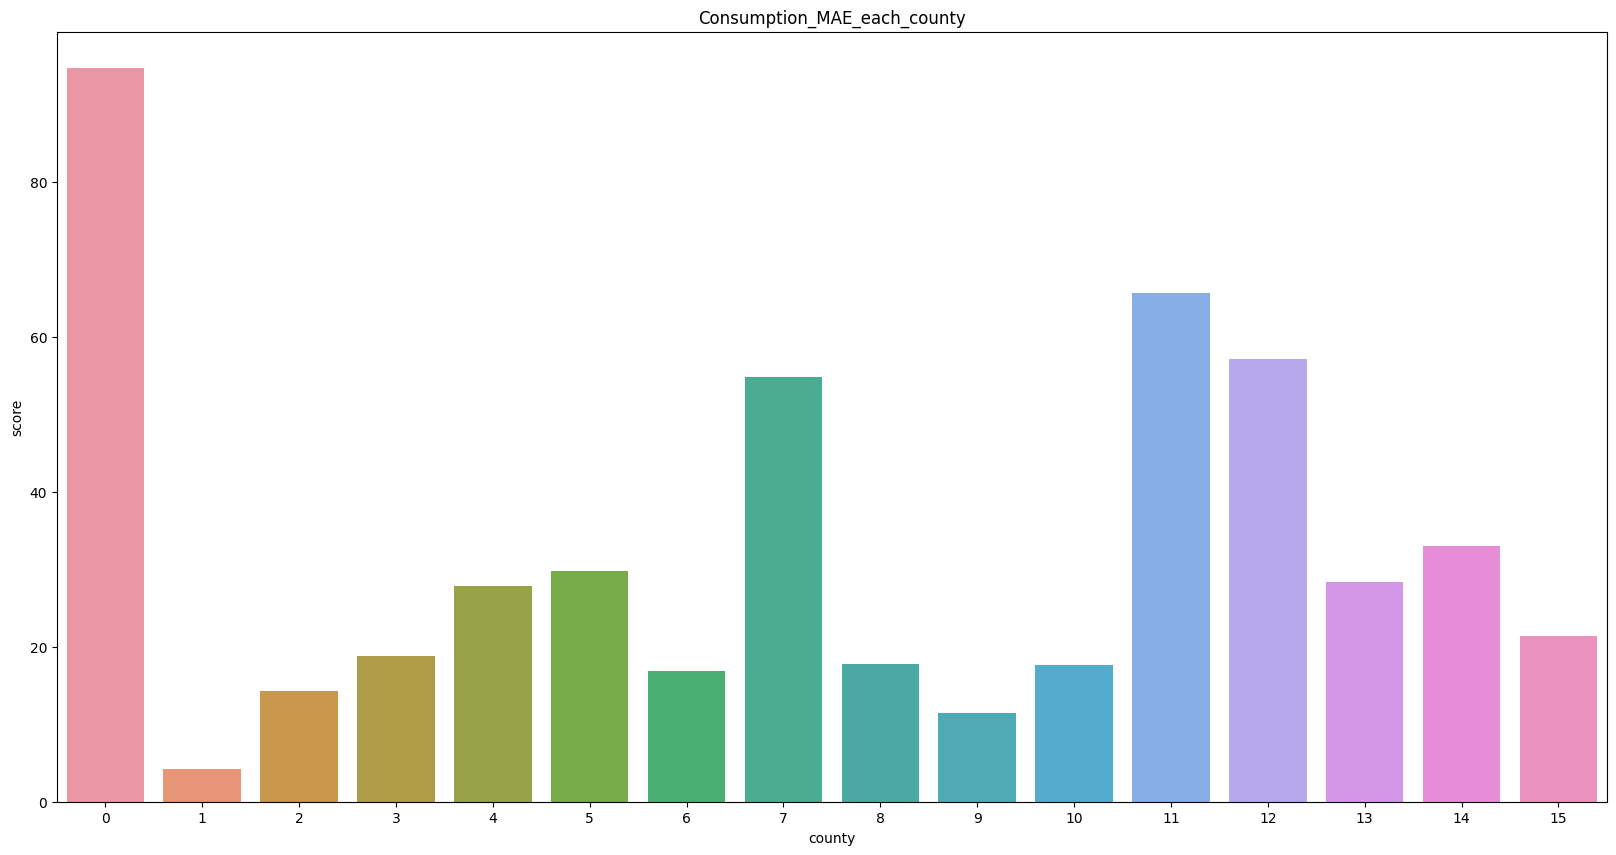

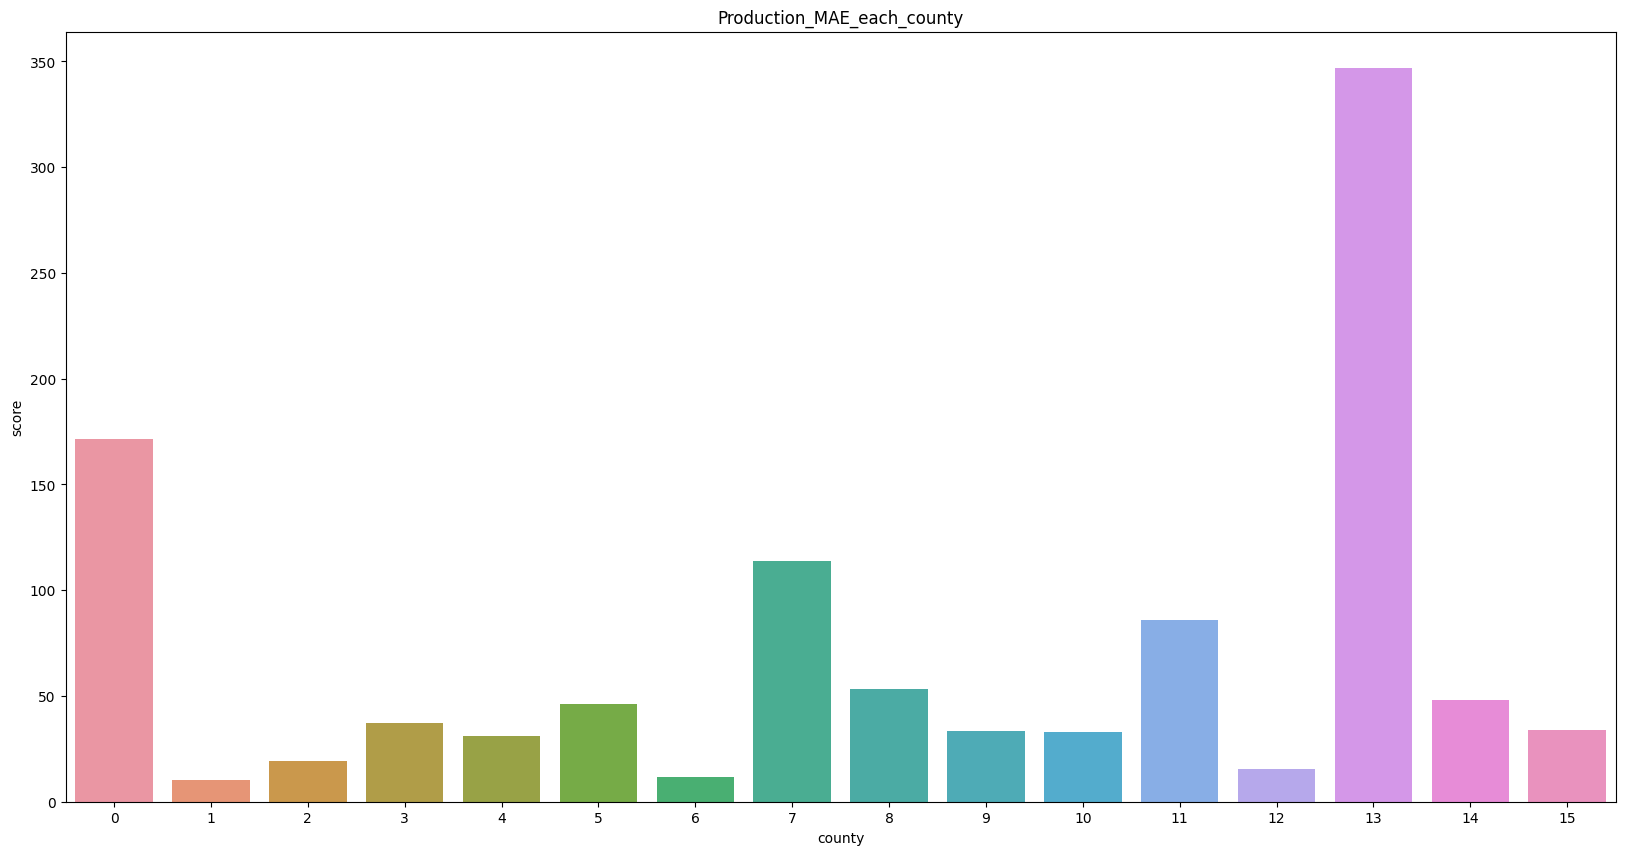

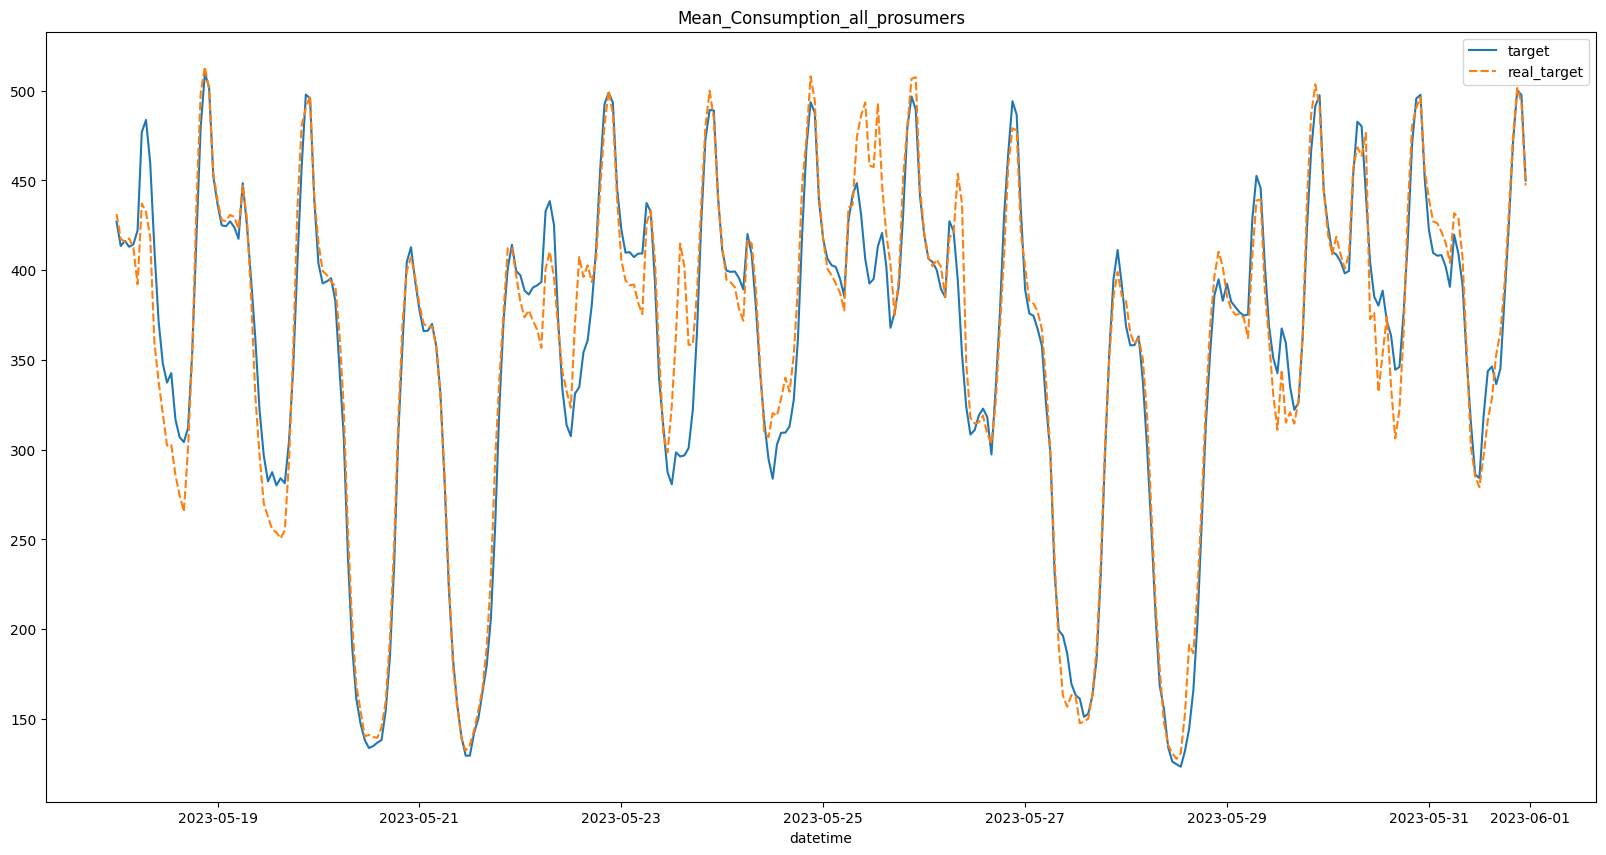

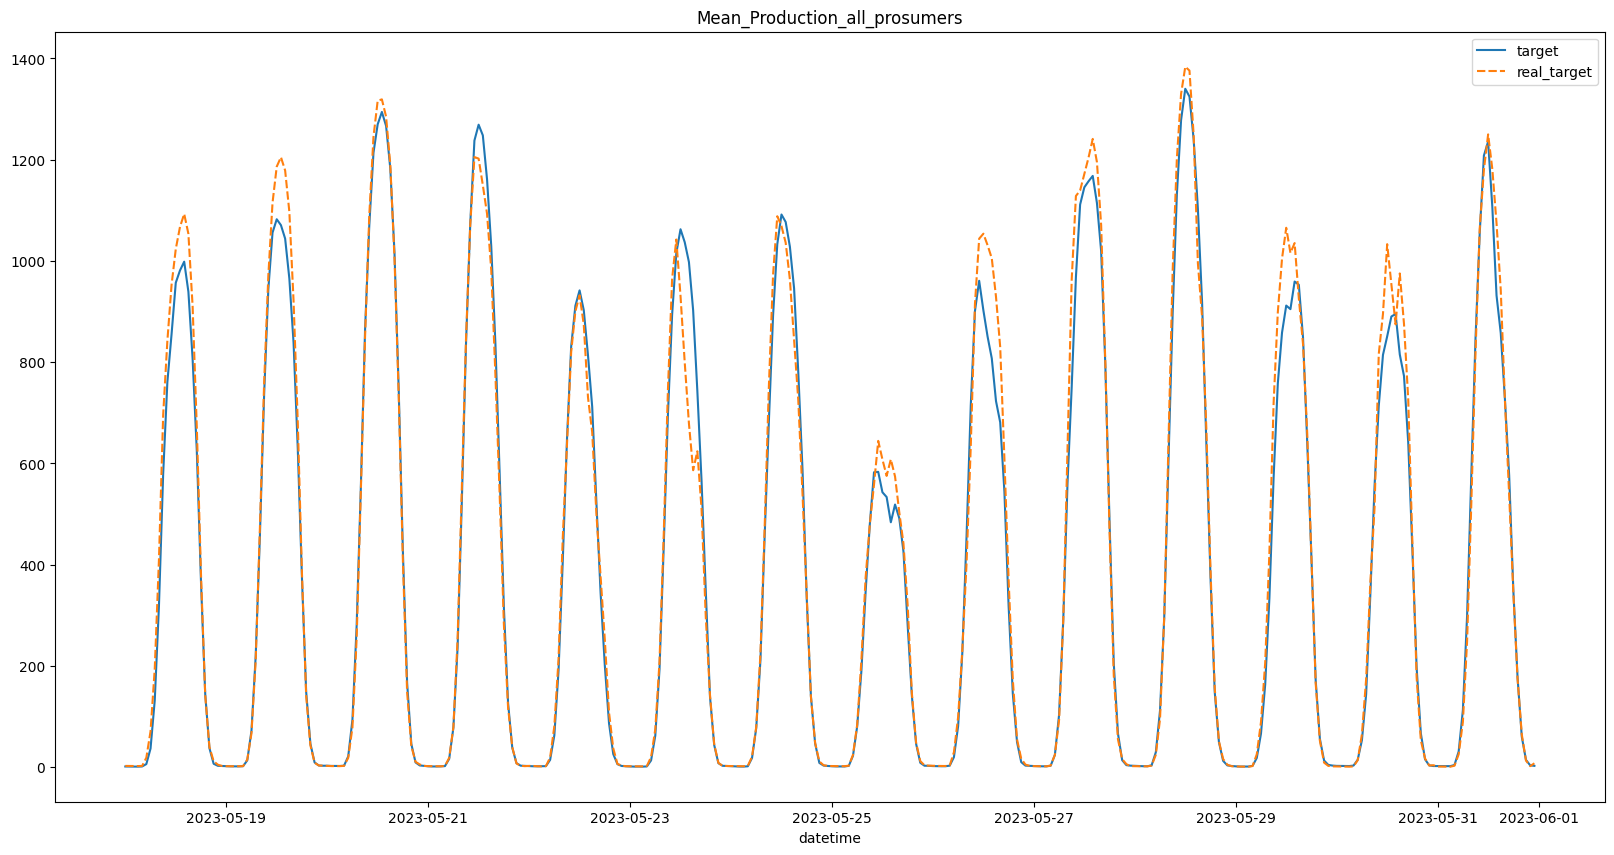

{'model_name': 'ensembled_model', 'MAE': 57.43878683350147}

In [7]:
validation.calculate_validation_score(
    features_generator_class=FeaturesGenerator,
    model=Model()
)